Script to try metrics on training set data and choose thresholds

In [1]:
%matplotlib inline
#%matplotlib
import cv2 
import imageio
import pickle
import pydicom
import random
import numpy as np
import pandas as pd
from glob import glob
import matplotlib.pyplot as plt
from skimage.measure import label, regionprops
from skimage.segmentation import find_boundaries
from scipy.sparse import csr_matrix

import sys
sys.path.append('../metal')

In [2]:
def OCIndex2Label(index_open, index_close):
    """
    Converts from open and close index to frame-wise labels   
    
    Params
    -------
    index_open: int
    index_close: int
    
    Return
    -------
    frame_labels: numpy array of shape (1,50)
    
    """
    index_open = int(index_open)
    index_close = int(index_close)
    
    frame_labels = np.zeros([1,50]);
    if(index_close >= index_open):
        frame_labels[0,index_open:index_close] = 1
    else:
        frame_labels[0,index_open:50] = 1
        frame_labels[0,0:index_close] = 1
        
    return frame_labels   

In [3]:
def findAreaLabel(mask):
    '''
    function to find labels based on area of left atrium
    
    Input
    -----
    mask: float (50,208,174)
    
    Output
    -----
    label: float (1,50)
    
    '''
    area_la = np.sum(np.sum(mask==1.0,axis=2),axis=1) # area of left atrium
    
    # finding when mitral valve opens - when area is largest
    index_open = np.argmax(area_la)

    # finding when mitral valve closes - when area is smallest
    index_close = np.argmin(area_la)
    
    label = OCIndex2Label(index_open, index_close)
    
    # changing to 1-indexing from 0-indexing
    label = label + 1
    
    # adding abstain votes - exact location of open / close is uncertain
    label[:,index_open-3:index_open+2] = 0
    index_low = (index_close-3)%50
    index_high = (index_close+2)%50
    if(index_close+2 < 50 and index_close-3 >=0):
        label[:,index_low:index_high] = 0
    else:
        label[:,index_low:50] = 0
        label[:,0:index_high] = 0
    
    return label

In [4]:
def findPerimeterLabel(mask_original):
    '''
    function to find labels based on perimeter of left atrium
    
    Input
    -----
    mask_original: float (50,208,174)
    
    Output
    -----
    label: float (1,50)
    
    '''
    
    # finding perimeter of left atrium 
    mask = np.copy(mask_original)
    mask[mask!=1.0] = 0.0
    mask = mask.astype(int)
    perimeter = np.zeros((50,1))
    for frame in range(50):
        regions = regionprops(mask[frame])
        perimeter[frame] = regions[0].perimeter
        
    # mitral valve opens - when perimeter is largest
    index_open = np.argmax(perimeter)

    # mitral valve closes - when perimeter is smallest
    index_close = np.argmin(perimeter)
    
    label = OCIndex2Label(index_open, index_close)
    
    # changing to 1-indexing from 0-indexing
    label = label + 1
    
    # adding abstain votes - exact location of open / close is uncertain
    label[:,index_open-3:index_open+2] = 0
    index_low = (index_close-3)%50
    index_high = (index_close+2)%50
        
    if(index_close+2 < 50 and index_close-3 >=0):
        label[:,index_low:index_high] = 0
    else:
        label[:,index_low:50] = 0
        label[:,0:index_high] = 0
    
    return label

In [5]:
def findIntensityLabel(data, mask_original):
    '''
    function to define labels based on intensity within left atrium
    
    Input
    -----
    data: float (50,208,174)
    mask_original: float (50,208,174)
    
    Output
    -----
    label: float (1,50)
    
    '''
    # avg intensity within segment
    #mask = [mask_original == 1.0] 
    mask = np.copy(mask_original)
    mask[mask!=1.0] = 0.0
    mask = mask.astype(float)
    area_intensity = np.mean(np.mean(np.multiply(mask,data),axis=2),axis=1)
        
    # finding when mitral valve opens - when area is largest
    index_open = np.argmax(area_intensity)

    # finding when mitral valve closes - when area is smallest
    index_close = np.argmin(area_intensity)
    
    label = OCIndex2Label(index_open, index_close)
    
    # changing to 1-indexing from 0-indexing
    label = label + 1
    
    # adding abstain votes - exact location of open / close is uncertain
    label[:,index_open-3:index_open+2] = 0
    index_low = (index_close-4)%50
    index_high = (index_close+3)%50
    if(index_close+2 < 50 and index_close-3 >=0):
        label[:,index_low:index_high] = 0
    else:
        label[:,index_low:50] = 0
        label[:,0:index_high] = 0
        
    return label

In [6]:
def findIntensityLabel2(data, mask_original):
    '''
    function to define labels based on intensity along perimeter of left atrium
    
    Input
    -----
    data: float (50,208,174)
    mask: float (50,208,174)
    
    Output
    -----
    label: float (1,50)
    
    '''
    # avg intensity within segment
    #mask = [mask_original == 1.0] 
    mask = np.copy(mask_original)
    mask[mask!=1.0] = 0.0
    mask = mask.astype(int)
    boundary = find_boundaries(mask,mode='outer')
    intensity = np.mean(np.mean(np.multiply(boundary,data),axis=2),axis=1)
        
    # finding when mitral valve opens - when area is largest
    index_open = np.argmax(intensity)

    # finding when mitral valve closes - when area is smallest
    index_close = np.argmin(intensity)
    
    label = OCIndex2Label(index_open, index_close)
    
    # changing to 1-indexing from 0-indexing
    label = label + 1
    
    # adding abstain votes - exact location of open / close is uncertain
    label[:,index_open-3:index_open+2] = 0
    index_low = (index_close-4)%50
    index_high = (index_close+3)%50
    if(index_close+2 < 50 and index_close-3 >=0):
        label[:,index_low:index_high] = 0
    else:
        label[:,index_low:50] = 0
        label[:,0:index_high] = 0
    
    return label

In [7]:
def findLabelPrior():
    index_open = 20
    index_close = 1
    
    label = OCIndex2Label(index_open,index_close)
    
    # changing to 1-indexing from 0-indexing
    label = label + 1
    
    # adding abstain votes - exact location of open / close is uncertain
    label[:,index_open-3:index_open+2] = 0
    index_low = (index_close-4)%50
    index_high = (index_close+3)%50
    if(index_close+2 < 50 and index_close-3 >=0):
        label[:,index_low:index_high] = 0
    else:
        label[:,index_low:50] = 0
        label[:,0:index_high] = 0
        
    return label

In [8]:
# define 80% coverage labelling functions
#import import_ipynb
#import labelling_functions_3

def findOCLFs(data,mask):
    '''
    Function computes the LFs for the given data
    Saves the numpy array for each individual PID in the folder specified
    '''
    L = np.zeros((50,5))
    L[:,0] = np.squeeze(np.transpose(findAreaLabel(mask)))
    L[:,1] = np.squeeze(np.transpose(findPerimeterLabel(mask)))
    L[:,2] = np.squeeze(np.transpose(findIntensityLabel(data,mask)))
    L[:,3] = np.squeeze(np.transpose(findIntensityLabel2(data,mask)))
    L[:,4] = np.squeeze(np.transpose(findLabelPrior()))
    #L = L + 1
    
    return L

In [9]:
# call labelling functions, define majority vote classifier 
# return prediction probabilities
import sys
sys.path.append('../heart_mri/metal')
from metal.label_model.baselines import MajorityLabelVoter

def findMajorityPred(data,mask):
    L = findOCLFs(data,mask)
    
    mv = MajorityLabelVoter(seed=123)
    prob = mv.predict_proba(L)
    
    return prob

In [10]:
# define which frames are picked using prediction probabilities 
def findClosedFrames(data,mask):
    prob = findMajorityPred(data,mask)
    
    prob = prob[:,0]
    closed_frames = [i for i,x in enumerate(prob) if x == 1.0]
    
    # returning the first 10 closed frames
    if len(closed_frames) > 10:
        closed_frames = closed_frames[:10]
        
    return closed_frames

In [11]:
def findLeftArea(mask):
    area = np.sum(np.sum(mask==1.0,axis=2),axis=1) # area of left atrium
    return area

In [12]:
def findRightArea(mask):
    area = np.sum(np.sum(mask==2.0,axis=2),axis=1) # area of left atrium
    return area

In [13]:
def findLeftPerimeter(mask_original):
    #mask = [mask_original == 1.0] 
    mask = np.copy(mask_original)
    mask[mask!=1.0] = 0.0
    mask = mask.astype(int)
    perimeter = np.zeros((50,1))
    for frame in range(50):
        regions = regionprops(mask[frame])
        perimeter[frame] = regions[0].perimeter
    
    return perimeter

In [14]:
def findRightPerimeter(mask_original):
    #mask = [mask_original == 2.0] 
    mask = np.copy(mask_original)
    mask[mask!=2.0] = 0.0
    mask = mask.astype(int)
    perimeter = np.zeros((50,1))
    for frame in range(50):
        regions = regionprops(mask[frame])
        perimeter[frame] = regions[0].perimeter
    
    return perimeter

In [15]:
def findLeftEF(data,mask):
    area = findLeftArea(mask)
    
    #frames = findClosedFrames(data,mask)
    #area = area[frames]
    
    ejection_fraction = min(area)/max(area)
    return ejection_fraction

In [16]:
def findRightEF(data,mask):
    area = findRightArea(mask)
    
    #frames = findClosedFrames(data,mask)
    #area = area[frames]
    
    ejection_fraction = min(area)/max(area)
    return ejection_fraction

In [17]:
def findLeftAreaVar(data,mask):
    area = findLeftArea(mask)
    
    #frames = findClosedFrames(data,mask)
    #area = area[frames]
    
    area_var = np.var(area)
    return area_var

In [18]:
def findRightAreaVar(data,mask):
    area = findRightArea(mask)
    
    #frames = findClosedFrames(data,mask)
    #area = area[frames]
    
    area_var = np.var(area)
    return area_var

In [19]:
def findFrameAreaRatio(data,mask):
    left_area = findLeftArea(mask)
    right_area = findRightArea(mask)
    
    #frames = findClosedFrames(data,mask)
    #area_ratio = np.mean(np.divide(left_area[frames],right_area[frames]))
    area_ratio = np.mean(np.divide(left_area,right_area))        
    return area_ratio

In [20]:
def findFrameRatioVar(data,mask):
    left_area = findLeftArea(mask)
    right_area = findRightArea(mask)
    
    #frames = findClosedFrames(data,mask)
    #ratio_var = np.var(np.divide(left_area[frames],right_area[frames]))  
    ratio_var = np.var(np.divide(left_area,right_area))   
    return ratio_var

In [21]:
def findAreaPerimeterRatio(data,mask):
    area=  findLeftArea(mask)
    perimeter = findLeftPerimeter(mask)

    #ratio = np.divide(area, np.power(perimeter,2))
    ratio = np.divide(area, perimeter)
    
    #frames = findClosedFrames(data,mask)
    #ratio = ratio[frames]
    
    return np.nanmean(ratio)

In [22]:
def findAreaPerimeterRatioVar(data,mask):
    area=  findLeftArea(mask)
    perimeter = findLeftPerimeter(mask)
    
    #ratio = np.divide(area, np.power(perimeter,2))
    ratio = np.divide(area, perimeter)
    
    #frames = findClosedFrames(data,mask)
    #ratio = ratio[frames]
    
    return np.nanvar(ratio)

In [23]:
def findLeftAtriumIntensity(data,mask):
    masked_data = np.multiply(data,mask)
    frames = findClosedFrames(data,mask)
    
    masked_data = masked_data[frames,:,:]
    masked_data = np.reshape(masked_data,(len(frames),-1))
    
    area_intensity = np.mean(masked_data,axis=1)
    return area_intensity
    

In [24]:
def findLeftAtriumIntensityVar(data,mask):
    masked_data = np.multiply(data,mask)
    frames = findClosedFrames(data,mask)
    
    masked_data = masked_data[frames,:,:]
    masked_data = np.reshape(masked_data,(len(frames),-1))
    
    area_intensity_var = np.var(masked_data,axis=1)
    return area_intensity_var

In [25]:
data_path = '../data/mr/train/'
labels = pd.read_csv(data_path+'labels.csv')

In [26]:
data_PIDs = labels.ID
data_labels = labels.LABEL 

print(data_PIDs.shape)
print(data_labels.shape)

(250,)
(250,)


In [27]:
MR_indices = [i for i,x in enumerate(data_labels) if x == 1.0]
nonMR_indices = [i for i,x in enumerate(data_labels) if x == 0.0]

MR_PIDs = data_PIDs[MR_indices[:]]
nonMR_PIDs = data_PIDs[nonMR_indices[:]]

In [28]:
# loading data and mask
data = {}
mask = {} 
Y = {}
for PID in MR_PIDs:
    print(PID)
    data[PID] = np.load(data_path+'la_4ch/'+str(PID)+'.npy')
    mask[PID] = np.load(data_path+'la_4ch_mask/'+str(PID)+'.npy')
    Y[PID] = 1    
    
for PID in nonMR_PIDs:
    print(PID)
    data[PID] = np.load(data_path+'la_4ch/'+str(PID)+'.npy')
    mask[PID] = np.load(data_path+'la_4ch_mask/'+str(PID)+'.npy')
    Y[PID] = 0   

3085128
5144603
3081388
1298891
5786505
3732743
3731562
2002329
4730312
3995191
3200115
3844741
4254850
2417922
4348411
4585988
3749507
3340464
1433516
5936415
1631970
2370818
1582477
5786533
1617662
2340116
2705213
5763523
4313102
3753065
3251632
1370027
2250584
4311498
5700281
1435741
1350437
2568581
3734841
4325127
3940729
4952970
2106029
1030923
4358938
2711126
2046732
3462299
3181580
1196573
4545229
1429283
5179406
2531664
1708007
1478393
4056607
4244727
4019183
2034606
5165760
4427699
1730457
3588464
2058577
5192367
1116409
1777810
2004622
3110680
4682829
1153521
5936118
1700356
2521956
4491598
4398876
2907944
3796328
1429339
2859646
3827005
2297974
5926710
1974956
2062304
4053952
1055258
5374563
3047016
5156063
5142661
4517061
3844591
4971674
2714044
1573135
2261024
2891002
1231639
3771468
1977256
5151591
2898000
5014270
5137076
2915312
3908654
5181584
5409965
2352132
4963163
3377733
2275055
2285395
3683918
2435409
4346110
2047467
1869465
4417273
4605844
1111826
3263717
6026141


In [29]:
MR_left_EF = []
nonMR_left_EF = [] 
MR_right_EF = []
nonMR_right_EF = [] 
MR_left_var = []
nonMR_left_var = []
MR_right_var = []
nonMR_right_var = []
MR_area_ratio = []
nonMR_area_ratio = []
MR_ratio_var = []
nonMR_ratio_var = []
MR_area_perimeter_ratio = []
nonMR_area_perimeter_ratio = []
MR_area_perimeter_ratio_var = []
nonMR_area_perimeter_ratio_var = []

MR_atrium_intensity = np.zeros((25,10))
nonMR_atrium_intensity = np.zeros((225,10))
MR_atrium_intensity_var = np.zeros((25,10))
nonMR_atrium_intensity_var = np.zeros((225,10))

count = 0
for PID in MR_PIDs:
    MR_left_EF.append(findLeftEF(data[PID],mask[PID]))
    MR_right_EF.append(findRightEF(data[PID],mask[PID]))
    MR_left_var.append(findLeftAreaVar(data[PID],mask[PID]))
    MR_right_var.append(findRightAreaVar(data[PID],mask[PID]))
    MR_area_ratio.append(findFrameAreaRatio(data[PID],mask[PID]))
    MR_ratio_var.append(findFrameRatioVar(data[PID],mask[PID]))
    MR_area_perimeter_ratio.append(findAreaPerimeterRatio(data[PID],mask[PID]))
    MR_area_perimeter_ratio_var.append(findAreaPerimeterRatioVar(data[PID],mask[PID]))
    
    MR_atrium_intensity[count,:] = findLeftAtriumIntensity(data[PID],mask[PID])
    MR_atrium_intensity_var[count,:] = findLeftAtriumIntensityVar(data[PID],mask[PID])
    count = count+1
    
count = 0
for PID in nonMR_PIDs:
    nonMR_left_EF.append(findLeftEF(data[PID],mask[PID]))
    nonMR_right_EF.append(findRightEF(data[PID],mask[PID]))
    nonMR_left_var.append(findLeftAreaVar(data[PID],mask[PID]))
    nonMR_right_var.append(findRightAreaVar(data[PID],mask[PID]))
    nonMR_area_ratio.append(findFrameAreaRatio(data[PID],mask[PID]))
    nonMR_ratio_var.append(findFrameRatioVar(data[PID],mask[PID]))
    nonMR_area_perimeter_ratio.append(findAreaPerimeterRatio(data[PID],mask[PID]))
    nonMR_area_perimeter_ratio_var.append(findAreaPerimeterRatioVar(data[PID],mask[PID]))
    
    nonMR_atrium_intensity[count,:] = findLeftAtriumIntensity(data[PID],mask[PID])
    nonMR_atrium_intensity_var[count,:] = findLeftAtriumIntensityVar(data[PID],mask[PID])
    count = count+1
    

MR_atrium_intensity = np.reshape(MR_atrium_intensity,(250,))
nonMR_atrium_intensity = np.reshape(nonMR_atrium_intensity,(2250,))
MR_atrium_intensity_var = np.reshape(MR_atrium_intensity_var,(250,))
nonMR_atrium_intensity_var = np.reshape(nonMR_atrium_intensity_var,(2250,))

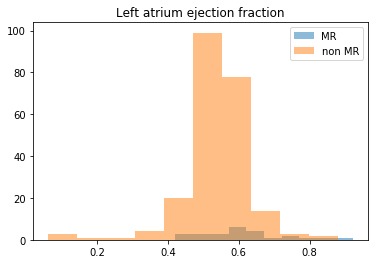

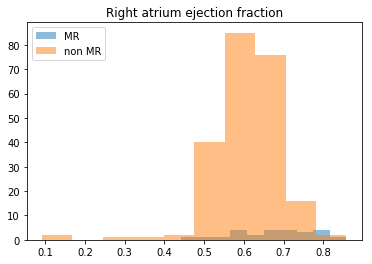

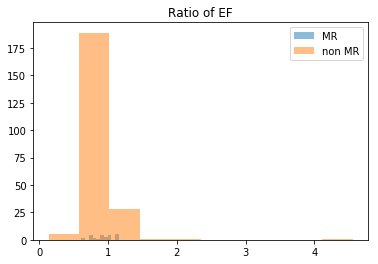

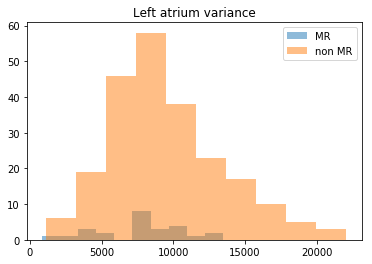

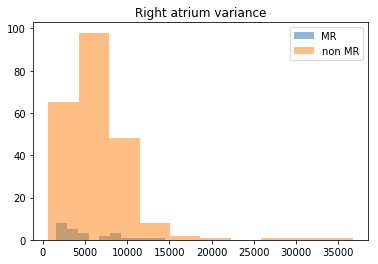

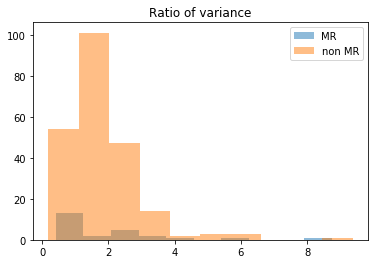

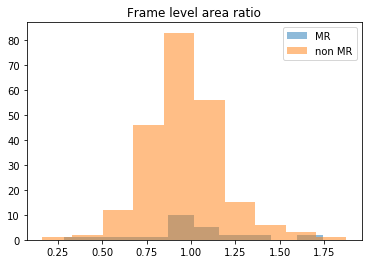

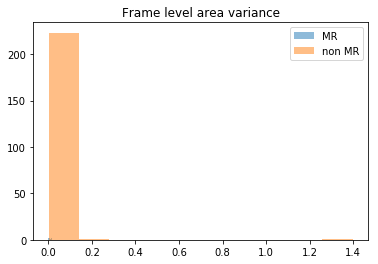

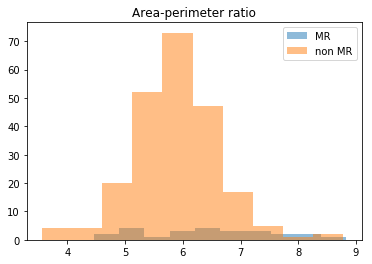

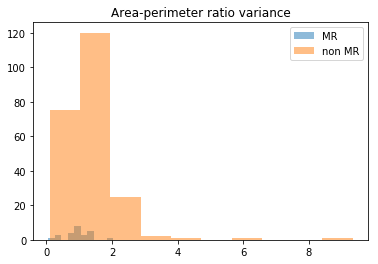

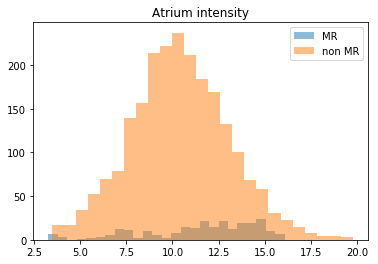

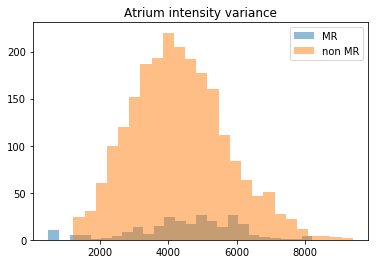

In [30]:
plt.figure()
plt.hist(MR_left_EF, bins=10, alpha = 0.5, label='MR')
plt.hist(nonMR_left_EF, bins=10, alpha = 0.5, label='non MR')
plt.legend()
plt.title('Left atrium ejection fraction')
plt.show()


plt.figure()
plt.hist(MR_right_EF, bins=10, alpha = 0.5, label='MR')
plt.hist(nonMR_right_EF, bins=10, alpha = 0.5, label='non MR')
plt.legend()
plt.title('Right atrium ejection fraction')
plt.show()

plt.figure()
plt.hist(np.divide(MR_left_EF, MR_right_EF), bins=10, alpha = 0.5, label='MR')
plt.hist(np.divide(nonMR_left_EF, nonMR_right_EF), bins=10, alpha = 0.5, label='non MR')
plt.legend()
plt.title('Ratio of EF')
plt.show()

plt.figure()
plt.hist(MR_left_var, bins=10, alpha = 0.5, label='MR')
plt.hist(nonMR_left_var, bins=10, alpha = 0.5, label='non MR')
plt.legend()
plt.title('Left atrium variance')
plt.show()

plt.figure()
plt.hist(MR_right_var, bins=10, alpha = 0.5, label='MR')
plt.hist(nonMR_right_var, bins=10, alpha = 0.5, label='non MR')
plt.legend()
plt.title('Right atrium variance')
plt.show()


plt.figure()
plt.hist(np.divide(MR_left_var, MR_right_var), bins=10, alpha = 0.5, label='MR')
plt.hist(np.divide(nonMR_left_var, nonMR_right_var), bins=10, alpha = 0.5, label='non MR')
plt.legend()
plt.title('Ratio of variance')
plt.show()


plt.figure()
plt.hist(MR_area_ratio, bins=10, alpha = 0.5, label='MR')
plt.hist(nonMR_area_ratio, bins=10, alpha = 0.5, label='non MR')
plt.legend()
plt.title('Frame level area ratio')
plt.show()


plt.figure()
plt.hist(MR_ratio_var, bins=10, alpha = 0.5, label='MR')
plt.hist(nonMR_ratio_var, bins=10, alpha = 0.5, label='non MR')
plt.legend()
plt.title('Frame level area variance')
plt.show()

plt.figure()
plt.hist(MR_area_perimeter_ratio, bins=10, alpha = 0.5, label='MR')
plt.hist(nonMR_area_perimeter_ratio, bins=10, alpha = 0.5, label='non MR')
plt.legend()
plt.title('Area-perimeter ratio')
plt.show()

plt.figure()
plt.hist(MR_area_perimeter_ratio_var, bins=10, alpha = 0.5, label='MR')
plt.hist(nonMR_area_perimeter_ratio_var, bins=10, alpha = 0.5, label='non MR')
plt.legend()
plt.title('Area-perimeter ratio variance')
plt.show()


plt.figure()
plt.hist(MR_atrium_intensity, bins=25, alpha = 0.5, label='MR')
plt.hist(nonMR_atrium_intensity, bins=25, alpha = 0.5, label='non MR')
plt.legend()
plt.title('Atrium intensity')
plt.show()

plt.figure()
plt.hist(MR_atrium_intensity_var, bins=25, alpha = 0.5, label='MR')
plt.hist(nonMR_atrium_intensity_var, bins=25, alpha = 0.5, label='non MR')
plt.legend()
plt.title('Atrium intensity variance')
plt.show()

In [ ]:
# choosing thresholds for some metrics using all frames
# left atrium ejection fraction - if > 0.7 - MR, else abstain
# right atrium ejection fraction - if > 0.76 - MR, else abstain
# left atrium variance - if > 15000 non MR, else abstain
# right atrium variance - if > 12000 MR, else abstain
# frame area ratio - if <0.6 or > 1.6 MR (few examples) , else abstain
# area-perimeter ratio - if > 7.3 MR, else abstain
# area-perimeter ratio variance - if > 1.5 nonMR, else abstain


In [ ]:
# choosing thresholds for some metrics - using only 10 closed frames
# left atrium ejection fraction - if > 0.84 - MR, else abstain
# right atrium ejection fraction - if > 0.75 - MR, else abstain
# left atrium variance - if > 7000 non MR, else abstain
# frame area ratio - if <0.6 or > 1.6 MR (few examples) , else abstain
# area-perimeter ratio - if > 8 MR, else abstain
# area-perimeter ratio variance - if > 1.5 nonMR, else abstain


# for atrium intensity and variance - to try and reduce region considered

In [34]:
# given centroids and mask for a single frame - 
# defines a half plane based on centroids
# multiplies with mask 
def findSubregionFrame(c_left,c_right,mask):
    '''
    c_left: (x1, y1) float
    c_right: (x2, y2) float
    mask: (208, 180) float
    '''
    x1 = c_left[0]
    y1 = c_left[1]
    
    x2 = c_right[0]
    y2 = c_right[1]
    
    slope = ( x2 - x1 ) / ( y2 - y1 ) # flipped because of row/col convention in indexing
    new_mask = np.zeros(mask.shape)
    
    for x in range(mask.shape[0]):
        for y in range(mask.shape[1]):
            if(x > slope*(y-y1) + x1):
                new_mask[x,y] = 1
                
    new_mask = new_mask*mask
    new_mask[new_mask!=1.0] = 0
    
    return new_mask

In [35]:
def findSubregion(mask_original):
    '''
    Input
    ------
    mask_original: (50, 208, 180) float
    
    
    Output
    ------
    new_mask: (50, 208, 180) float
    mask defining a smaller region
    '''
    
    # finding left and right atrium masks
    mask_left = np.copy(mask_original)
    mask_left[mask_left!=1.0] = 0.0
    mask_left = mask_left.astype(int)

    mask_right = np.copy(mask_original)
    mask_right[mask_right!=2.0] = 0.0
    mask_right = mask_right.astype(int)
    
    # finding centroids
    centroid_left = np.zeros((50,2))
    centroid_right = np.zeros((50,2))
    for frame in range(50):
        left_region = regionprops(mask_left[frame])
        centroid_left[frame] = left_region[0].centroid

        right_region = regionprops(mask_right[frame])
        centroid_right[frame] = right_region[0].centroid
        
    # finding subregions
    new_mask = np.zeros(mask_original.shape)
    for frame in range(mask_original.shape[0]):
        new_mask[frame,:,:] = findSubregionFrame(centroid_left[frame,:],centroid_right[frame,:],
                         mask_original[frame,:,:])
    
    return new_mask

3085128


Text(0.5, 1.0, 'new masked data')

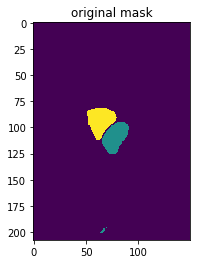

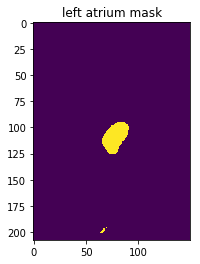

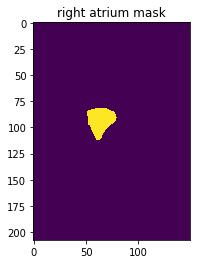

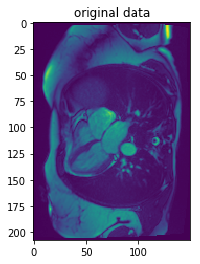

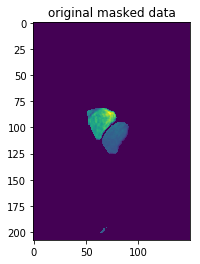

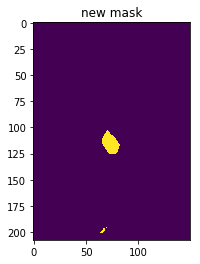

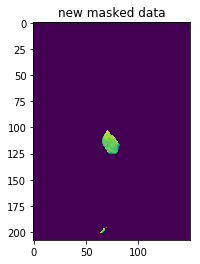

In [37]:
# using example to check if centroids can be used to define subregion 

PID = data_PIDs[MR_indices[0]]
print(PID)

data_eg = np.array(data[PID])
mask_eg = np.array(mask[PID])
masked_data = np.multiply(data_eg,mask_eg)

# finding region of interest
# finding masks
mask_left = np.copy(mask_eg)
mask_left[mask_left!=1.0] = 0.0
mask_left = mask_left.astype(int)

mask_right = np.copy(mask_eg)
mask_right[mask_right!=2.0] = 0.0
mask_right = mask_right.astype(int)

# finding centroids
centroid_left = np.zeros((50,2))
centroid_right = np.zeros((50,2))
for frame in range(50):
    left_region = regionprops(mask_left[frame])
    centroid_left[frame] = left_region[0].centroid
    
    right_region = regionprops(mask_right[frame])
    centroid_right[frame] = right_region[0].centroid
    

    
frame_num = 10

plt.figure()
plt.imshow(mask_eg[frame_num,:,:])
plt.title('original mask')

plt.figure()
plt.imshow(mask_left[frame_num,:,:])
plt.title('left atrium mask')

plt.figure()
plt.imshow(mask_right[frame_num,:,:])
plt.title('right atrium mask')


plt.figure()
plt.imshow(data_eg[frame_num,:,:])
plt.title('original data')

plt.figure()
plt.imshow(masked_data[frame_num,:,:])
plt.title('original masked data')

new_mask = findSubregionFrame(centroid_left[frame_num,:],centroid_right[frame_num,:],
                         mask_eg[frame_num,:,:])

plt.figure()
plt.imshow(new_mask)
plt.title('new mask')


plt.figure()
plt.imshow(np.multiply(data_eg[frame_num,:,:],new_mask))
plt.title('new masked data')

In [38]:
def findLeftAtriumIntensity1(data,mask):
    new_mask = findSubregion(mask)
    masked_data = np.multiply(data,new_mask)
    
    frames = findClosedFrames(data,mask)
    masked_data = masked_data[frames,:,:]
    masked_data = np.reshape(masked_data,(len(frames),-1))
    
    area_intensity = np.mean(masked_data,axis=1)
    return area_intensity

In [39]:
def findLeftAtriumIntensityVar1(data,mask):
    new_mask = findSubregion(mask)
    masked_data = np.multiply(data,new_mask)
    
    frames = findClosedFrames(data,mask)
    masked_data = masked_data[frames,:,:]
    masked_data = np.reshape(masked_data,(len(frames),-1))
    
    area_intensity_var = np.var(masked_data,axis=1)
    return area_intensity_var

In [40]:
def findLeftAtriumIntensity2(data,mask):
    new_mask = findSubregion(mask)
    masked_data = np.multiply(data,new_mask)
    
    frames = findClosedFrames(data,mask)
    masked_data = masked_data[frames,:,:]
    masked_data = np.reshape(masked_data,(len(frames),-1))
    
    #import ipdb; ipdb.set_trace()
    area_intensity = np.zeros((len(frames),))
    for frame in range(len(frames)):
        masked_data_frame = masked_data[frame,:]
        masked_data_frame = masked_data_frame[masked_data_frame!=0.0]
        area_intensity[frame] = np.mean(masked_data_frame)
    
    return area_intensity

In [41]:
def findLeftAtriumIntensityVar2(data,mask):
    new_mask = findSubregion(mask)
    masked_data = np.multiply(data,new_mask)
    
    frames = findClosedFrames(data,mask)
    masked_data = masked_data[frames,:,:]
    masked_data = np.reshape(masked_data,(len(frames),-1))
        
    area_intensity_var = np.zeros((len(frames),))
    for frame in range(len(frames)):
        masked_data_frame = masked_data[frame,:]
        masked_data_frame = masked_data_frame[masked_data_frame!=0.0]
        area_intensity_var[frame] = np.var(masked_data_frame)
        
    return area_intensity_var

In [42]:
MR_atrium_intensity2 = np.zeros((25,10))
nonMR_atrium_intensity2 = np.zeros((225,10))
MR_atrium_intensity_var2 = np.zeros((25,10))
nonMR_atrium_intensity_var2 = np.zeros((225,10))

count = 0
for PID in MR_PIDs:
    print(PID)
    MR_atrium_intensity2[count,:] = findLeftAtriumIntensity2(data[PID],mask[PID])
    MR_atrium_intensity_var2[count,:] = findLeftAtriumIntensityVar2(data[PID],mask[PID])
    count = count+1
    
count = 0
for PID in nonMR_PIDs: 
    print(PID)
    nonMR_atrium_intensity2[count,:] = findLeftAtriumIntensity2(data[PID],mask[PID])
    nonMR_atrium_intensity_var2[count,:] = findLeftAtriumIntensityVar2(data[PID],mask[PID])
    count = count+1
    

MR_atrium_intensity2 = np.reshape(MR_atrium_intensity2,(250,))
nonMR_atrium_intensity2 = np.reshape(nonMR_atrium_intensity2,(2250,))
MR_atrium_intensity_var2 = np.reshape(MR_atrium_intensity_var2,(250,))
nonMR_atrium_intensity_var2 = np.reshape(nonMR_atrium_intensity_var2,(2250,))

3085128
5144603
3081388
1298891
5786505
3732743
3731562
2002329
4730312
3995191
3200115
3844741
4254850
2417922
4348411
4585988
3749507
3340464
1433516
5936415
1631970
2370818
1582477
5786533
1617662
2340116
2705213
5763523
4313102
3753065
3251632
1370027
2250584
4311498
5700281
1435741
1350437
2568581
3734841
4325127
3940729
4952970
2106029
1030923
4358938
2711126
2046732
3462299
3181580
1196573
4545229
1429283
5179406
2531664
1708007
1478393
4056607
4244727
4019183
2034606
5165760
4427699
1730457
3588464
2058577
5192367
1116409
1777810
2004622
3110680
4682829
1153521
5936118
1700356
2521956
4491598
4398876
2907944
3796328
1429339
2859646
3827005
2297974
5926710
1974956
2062304
4053952
1055258
5374563
3047016
5156063
5142661
4517061
3844591
4971674
2714044
1573135
2261024
2891002
1231639
3771468
1977256
5151591
2898000
5014270
5137076
2915312
3908654
5181584
5409965
2352132
4963163
3377733
2275055
2285395
3683918
2435409
4346110
2047467
1869465
4417273
4605844
1111826
3263717
6026141


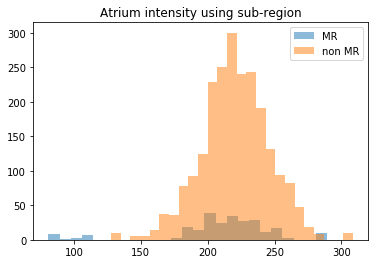

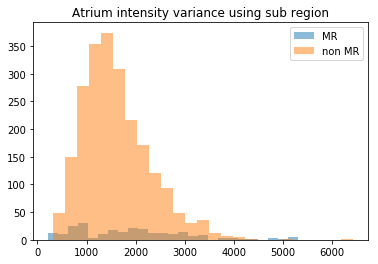

In [43]:
plt.figure()
plt.hist(MR_atrium_intensity2, bins=25, alpha = 0.5, label='MR')
plt.hist(nonMR_atrium_intensity2, bins=25, alpha = 0.5, label='non MR')
plt.legend()
plt.title('Atrium intensity using sub-region')
plt.show()

plt.figure()
plt.hist(MR_atrium_intensity_var2, bins=25, alpha = 0.5, label='MR')
plt.hist(nonMR_atrium_intensity_var2, bins=25, alpha = 0.5, label='non MR')
plt.legend()
plt.title('Atrium intensity variance using sub region')
plt.show()